In [1]:
import os

import numpy as np
from scipy.stats import sem
import gymnasium as gym

import gym_env
import seaborn as sns
import matplotlib.pyplot as plt

from utils import decision_policy

In [ ]:
class TwoStepStochastic:
    def __init__(self, size=7, prob_common=0.5, seed=None, stoch_states={1}):
        """
        Two-step task environment with stochastic transitions.
        
        Args:
            size: Number of states
            prob_common: Probability of common transition (default 0.5)
            seed: Random seed for reproducibility
        """
        self.size = size
        self.prob_common = prob_common
        self.rng = np.random.RandomState(seed)
        
        self.envstep = self._build_transition_table()
        self.stochastic_states = stoch_states
        
    def _build_transition_table(self):
        """Build the base transition lookup table."""
        envstep = []
        for s in range(self.size):
            envstep.append([[0, 0], [0, 0]])
        envstep = np.array(envstep)
        
        # State 0 -> 1, 2 (deterministic)
        envstep[0, 0] = [1, 0]
        envstep[0, 1] = [2, 0]
        
        # State 1 -> 3, 4 (will be stochastic)
        envstep[1, 0] = [3, 1]  # common for action 0
        envstep[1, 1] = [4, 1]  # common for action 1
        
        # State 2 -> 5, 6 (not stochastic)
        envstep[2, 0] = [5, 1]  # common for action 0
        envstep[2, 1] = [6, 1]  # common for action 1
        
        return envstep
        
    def step_deterministic(self, state, action):
        state, done = self.envstep[state, action]
        return state, done

    def step(self, state, action):
        # Get the "common" transition for this action
        common_state, done = self.envstep[state, action]
        
        # Handle stochastic transitions
        if state in self.stochastic_states:
            if self.rng.random() < self.prob_common:
                # Common transition
                next_state = common_state
            else:
                # Rare transition (flip to the other action's common state)
                rare_action = 1 - action
                next_state = self.envstep[state, rare_action][0]
        else:
            # Deterministic transition
            next_state = common_state
            
        return next_state, done
    
    def reset(self):
        """Reset to initial state."""
        return 0
    
    def get_transition_type(self, state, action, next_state):
        if state not in self.stochastic_states:
            return 'deterministic'
        
        common_state = self.envstep[state, action][0]
        if next_state == common_state:
            return 'common'
        else:
            return 'rare'


# Usage example:
if __name__ == "__main__":
    env = TwoStepStochastic(size=7, prob_common=0.5)
    
    state = env.reset()
    print(f"Start state: {state}")
    
    # First step
    action = 0
    state, done = env.step(state, action)
    print(f"After action {action}: state={state}, done={done}")
    
    # Second step
    action = 1
    next_state, done = env.step(state, action)
    transition_type = env.get_transition_type(state, action, next_state)
    print(f"After action {action}: state={next_state}, done={done}, transition={transition_type}")

Start state: 0
After action 0: state=1, done=0
After action 1: state=4, done=1, transition=common


In [ ]:
class SR_IS_TwoStep:
    def __init__(self, alpha=0.25, beta=1.0, _lambda=1, num_steps=250, policy="softmax", imp_samp=True, seed=None):
        # Hard code start and end locations as well as size
        self.start_loc = 0
        self.target_locs = [3,4,5,6]
        self.start_locs = [0]
        self.size = 7
        self.agent_loc = self.start_loc
        self.seed = seed

        # Construct the transition probability matrix and env
        self.T = self.construct_T()
        self.env = TwoStepStochastic(size=7, prob_common=0.5, seed=self.seed)
        
        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]

        # Set reward
        self.reward_nt = -0.1
        self.r = np.full(len(self.T), self.reward_nt)
        # Reward of terminal states depends on if we are replicating reward revaluation or policy revaluation
        self.r[self.terminals] = [5,-5,0,1]

        # Precalculate exp(r) for use with LinearRL equations
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)
        self.expr_nt = np.exp(self.reward_nt / _lambda)

        # Params
        self.alpha = alpha
        self.beta = beta
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.num_steps = num_steps
        self.policy = policy
        self.imp_samp = imp_samp

        # Model
        self.DR = self.get_DR()
        self.Z = np.full(self.size, 0.01)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def construct_T(self):
        # For two-step task
        T = np.zeros((self.size, self.size))
        T[0, 1:3] = 0.5
        T[1, 3:5] = 0.5
        T[2, 5:7] = 0.5
        T[3:7, 3:7] = np.eye(4)

        return T

    def get_DR(self):
        if self.policy == "softmax":
            DR = np.full((self.size, self.size), 0.01)
            np.fill_diagonal(DR, 1)
            DR[np.where(self.terminals)[0], np.where(self.terminals)[0]] = (1/(self.gamma))
        else:
            DR = np.eye(self.size)

        return DR

    def update_Z(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = self.expr_t

    def update_V(self):
        self.V = np.log(self.Z) * self._lambda
    
    def get_successor_states(self, state):
        return np.where(self.T[state, :] != 0)[0]

    def importance_sampling(self, state, s_prob):
        successor_states = self.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state):
        if self.policy == "random":
            action = np.random.choice([0,1])

            return action
        
        elif self.policy == "softmax":
            successor_states = self.get_successor_states(state)
            action_probs = np.full(2, 0.0)   # We can hardcode this because every state has 2 actions

            v_sum = sum(np.exp((np.log(self.Z[s] + 1e-20) * self._lambda) / self.beta) for s in successor_states)

            # if we don't have enough info, random action
            if v_sum == 0:
                return  np.random.choice([0,1])

            for action in [0,1]:
                new_state, _ = self.env.step_deterministic(state, action)
                action_probs[action] = np.exp((np.log(self.Z[new_state] + 1e-20) * self._lambda) / self.beta ) / v_sum
                
            action = np.random.choice([0,1], p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob

    def get_D_inv(self):
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)
        
        return D_inv

    def learn(self):
        if self.seed is not None:
            np.random.seed(seed=self.seed)

        for i in range(self.num_steps):
            # Agent gets some knowledge of terminal state values
            if i == 2:
                self.Z[self.terminals] = self.expr_t
            state = self.agent_loc

            if self.policy == "softmax":
                action, s_prob = self.select_action(state)
            else:
                action = self.select_action(state)
        
            next_state, done = self.env.step(state, action)

            if self.imp_samp:
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
            else:
                w = 1
            
            target = self.one_hot[state] + self.gamma * self.DR[next_state]
            self.DR[state] = (1 - self.alpha) * self.DR[state] + self.alpha * target * w

            self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
            
            # print(f"state: {state}| action: {action}| next state: {next_state}")
            
            if done:
                self.agent_loc = self.start_loc
                continue
            
            # Update state
            state = next_state
            self.agent_loc = state

        # Update DR at terminal state
        self.update_Z()
        self.update_V()

In [4]:
set_val = 1
lambd = set_val
alpha = 0.1
alpha = 0.05
beta = set_val
num_steps = 250
num_seeds = 500

prob_s2 = []
prob_s3 = []

for i in range(num_seeds):
    seed = int(i)
    agent =  SR_IS_TwoStep(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, seed=seed)
    agent.learn()
    pii = decision_policy(agent, agent.Z)
    prob_s2.append(pii[0,1])
    prob_s3.append(pii[0,2])

In [5]:
print(f"Mean prob of S2: ({np.mean(prob_s2)}, {sem(prob_s2)}) | Mean prob of S3: ({np.mean(prob_s3)}, {sem(prob_s3)})")

Mean prob of S2: (0.9361234328426873, 0.0002928396469857265) | Mean prob of S3: (0.0638765671573127, 0.00029283964698572637)


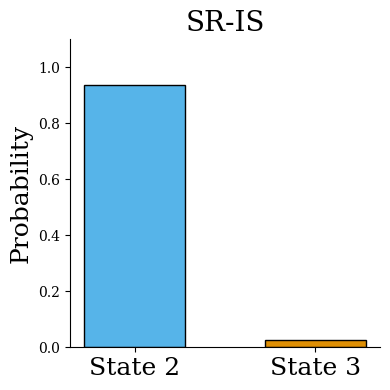

In [15]:
# Plot values
means = [np.mean(prob_s2), np.mean(prob_s3)]
std = [sem(prob_s2), sem(prob_s3)]

save_dir = os.path.join('..', 'figures/')
save_path = save_dir + "TwoStepStochastic_SR-IS.png"
# save_path = None
colors = [9, 1]

title = "SR-IS"
xlabels = ["State 2", "State 3"]
y_lim = None
ylabel = "Probability"

# Plot
color_palette = sns.color_palette("colorblind")
color_list = []
for color in colors:
    color_list.append(color_palette[color])

plt.rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(figsize=(4, 4))
x = np.arange(len(means)) * 0.25

plot_means = np.array(means, dtype=float).copy()
min_visible_height = 0.025
plot_means[plot_means < 0.1] = min_visible_height

bars = ax.bar(x, plot_means, color=color_list, edgecolor='black', linewidth=1, width=0.14)

if std is not None:
    ax.errorbar(x, means, yerr=std, fmt='none', color='black', capsize=0)

ax.set_ylabel(ylabel, fontsize=18)
ax.set_title(title, fontsize=20) if title else None
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=0, ha='center', fontsize=18)

if y_lim is None:
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    ax.set_ylim(0, 1.1)
else:
    ax.set_yticks(np.arange(y_lim[0], y_lim[1], 0.2))
    ax.set_ylim(y_lim[0], y_lim[1])

# for spine in ['left', 'right', 'bottom', 'top']:
#     ax.spines[spine].set_color('black')
#     ax.spines[spine].set_linewidth(1)

for spine in ['right', 'top']:
    ax.spines[spine].set_linewidth(0)

ax.grid(False)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()

if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

In [7]:
# import seaborn as sns
# import matplotlib.colors as mcolors

# # Get the colorblind palette
# colorblind_palette = sns.color_palette("colorblind")

# print("Seaborn Colorblind Palette RGB Values:")
# print("=" * 50)

# for i, color in enumerate(colorblind_palette):
#     # Convert from 0-1 range to 0-255 range
#     r = int(color[0] * 255)
#     g = int(color[1] * 255)
#     b = int(color[2] * 255)
    
#     print(f"Color {i}: RGB({r:3d}, {g:3d}, {b:3d}) | Normalized: ({color[0]:.3f}, {color[1]:.3f}, {color[2]:.3f})")

# print("=" * 50)